In [1]:
%matplotlib inline
import torch
from PIL import Image
import matplotlib.pyplot as plt
from pathlib import Path
import utils
from torchvision.io import image
from torchvision.transforms.functional import to_pil_image
import pandas as pd

In [2]:
img_catdog = Path('../data/img/catdog.jpg')

In [3]:
img = image.read_image(img_catdog.as_posix())
c, h, w = img.shape
w, h

(728, 561)

# 当使用较小的锚框检测较小的物体时，我们可以采样更多的区域，而对于较大的锚框，我们可以采样较少的区域。

In [4]:
def display_anchors(fmap_w, fmap_h, s):
    # 前两个维度上的值不影响输出
    fmap = torch.zeros((1, 10, fmap_h, fmap_w))
    # 原本是在img上各个像素上生成锚框，现在在一个小的特征图（4*4）上生成较少的锚框，返回的锚框是小数比例模式，可以作用在img上
    anchors = utils.multibox_prior(data=fmap, area_sizes=s, w_h_ratios=[1, 2, 0.5], w_h_ratios_normalization=False)
    bbox_scale = torch.tensor((w, h, w, h))
    img_pil = to_pil_image(img)
    utils.show_bboxes(plt.imshow(img_pil, aspect='equal').axes, anchors[0] * bbox_scale)

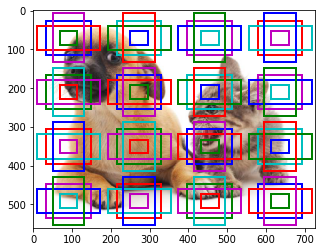

In [5]:
display_anchors(fmap_w=4, fmap_h=4, s=[0.025, 0.004])

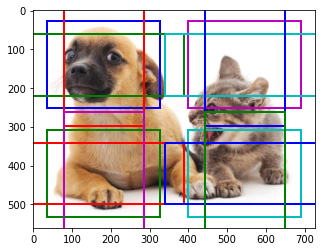

In [6]:
display_anchors(fmap_w=2, fmap_h=2, s=[0.16])

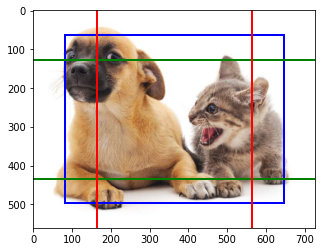

In [7]:
display_anchors(fmap_w=1, fmap_h=1, s=[0.6])

# 香蕉检测数据集

In [8]:
data_dir_name = 'banana-detection'
data_path = Path(rf'../data/{data_dir_name}')

In [9]:
def read_data_bananas(is_train=True):
    """读取香蕉检测数据集中的图像和标签"""
    train_or_valid_dir = data_path / 'bananas_train' if is_train else data_path / 'bananas_val'
    csv_fname = train_or_valid_dir / 'label.csv'
    csv_data = pd.read_csv(csv_fname.as_posix())
    csv_data = csv_data.set_index('img_name')
    images, targets = [], []
    for img_name, target in csv_data.iterrows():
        _img = image.read_image((train_or_valid_dir / 'images' / img_name).as_posix())
        images.append(_img)
        # 这里的target包含（类别，左上角x，左上角y，右下角x，右下角y），
        # 其中所有图像都具有相同的香蕉类（索引为0）
        targets.append(list(target))
    return images, torch.tensor(targets).unsqueeze(1) / 256    # 将坐标缩放到[0, 1]，类别为0，无影响

In [10]:
class BananasDataset(torch.utils.data.Dataset):
    """一个用于加载香蕉检测数据集的自定义数据集"""
    def __init__(self, is_train):
        self.features, self.labels = read_data_bananas(is_train)
        print(f'read {str(len(self.features))} {"training" if is_train else "validation"} examples')

    def __getitem__(self, idx):
        return (self.features[idx].float(), self.labels[idx])

    def __len__(self):
        return len(self.features)

In [11]:
def load_data_bananas(batch_size):
    """加载香蕉检测数据集"""
    train_iter = torch.utils.data.DataLoader(BananasDataset(is_train=True), batch_size, shuffle=True)
    valid_iter = torch.utils.data.DataLoader(BananasDataset(is_train=False), batch_size)
    return train_iter, valid_iter

In [12]:
batch_size, edge_size = 32, 256
train_iter, _ = load_data_bananas(batch_size)
batch_data, batch_label = next(iter(train_iter))
# batch_label的shape是(批量大小，边框数，类别+坐标)，每个图片边框数可能不同，所有图片中，存在拥有边框最大数m
# 将边框数不足m的用-1类别填充非法边界框，使其所有的shape一致
batch_data.shape, batch_label.shape

read 1000 training examples
read 100 validation examples


(torch.Size([32, 3, 256, 256]), torch.Size([32, 1, 5]))

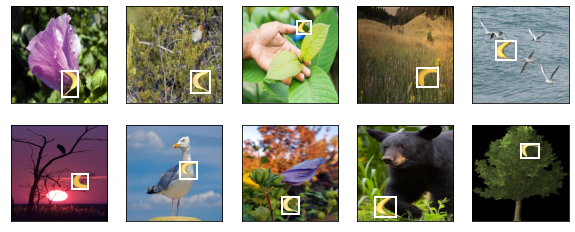

In [13]:
imgs = (batch_data[0:10].permute(0, 2, 3, 1)) / 255    # plt显示图片通道维度放最后，缩放到[0, 1]
axes = utils.show_images(imgs=imgs, num_rows=2, num_cols=5, scale=2)
for ax, label in zip(axes, batch_label[0:10]):
    utils.show_bboxes(ax, [label[0][1:5] * edge_size], colors=['w'])